The dataset contains betting odds where each number is a ratio of the payoff,
including the gambler's stake, to the stake.

Suppose we have a budget of £1,000 to bet on $k$ tennis matches played in $2015$, and we have access to data from 2000-2014. Let $\phi_{i,W}$ and $\phi_{i,L}$ be the amounts we bet on the winner and the loser in match $i$, respectively. We call the vector $\phi = (\phi_{1,W}, \phi_{1,L}, \dots, \phi_{k,W} , \phi_{k,L})$ the portfolio.

A Markowitz portfolio aims to maximise the expected profits while minimising the risk, measured by the variance of the profit, under a model which specifies the probabilities of each outcome in each match. Letting $R_{i,W}$, $R_{i,L}$ be the profit made on the bet on the winner and loser of match $i$, and $R =
\sum_{i=1}^K [R_{i,W} + R_{i,L}]$ be the total profit, we can formalise the problem as follows:
\begin{equation}
\underset{\phi \in \mathbb{R}^{2k}}{\operatorname{minimise}} -E(R) + \nu \text{Var}(R)
\end{equation}
subject to
\begin{equation}
    \phi_{i,W} > 0, \phi_{i,L} > 0 \quad \text{for} \quad i = 1, \dots, k, \quad \sum_{i=1}^k [\phi_{i,W} + \phi_{i,L}] = 1000.
\end{equation}
This can be expressed as a quadratic program. Let the vector of bets be $w \in \mathbb{R}^{2k}$. We order the elements such that for every match $i$, we have $w_{2i-1} = \phi_{i,W}$ and $w_{2i} = \phi_{i,L}$. The probability that the Winner actually wins as $p_i$, hence the probability that the Loser wins is $(1 - p_i)$.

We aim to minimise $-E(R) + \nu \text{Var}(R)$, which is equivalent to minimising expectation (maximising profit) and minimising variance.

In the standard QP form $\min (w^\top Q w - w^\top q)$, the term $w^\top q$ represents the expectation. Let $W_i$ and $L_i$ denote the betting odds.

*   If the Winner wins (probability $p_i$), then:
    *   Profit from bet on Winner: $\phi_{i,W}(W_i - 1)$
    *   Loss from bet on Loser: $-\phi_{i,L}$
*   If the Loser wins (probability $1 - p_i$), then:
    *   Profit from bet on Loser: $\phi_{i,L}(L_i - 1)$
    *   Loss from bet on Winner: $-\phi_{i,W}$

The expected return for match $i$ is:
\begin{equation}
    E(R_i) = p_i [\phi_{i,W}(W_i - 1) - \phi_{i,L}] + (1 - p_i) [\phi_{i,L}(L_i - 1) - \phi_{i,W}].
\end{equation}
Grouping the terms by the decision variables $\phi_{i,W}$ and $\phi_{i,L}$, the coefficient for $\phi_{i,W}$ is
\begin{equation}
    p_i(W_i - 1) - (1-p_i) = p_i W_i - 1,
\end{equation}
and the coefficient for $\phi_{i,L}$ is
\begin{equation}
    -p_i + (1-p_i)(L_i - 1) = (1-p_i)L_i - 1.
\end{equation}
Thus, the vector $q$ (of length $2k$) contains the expected return rates for each bet:
\begin{equation}
    q =
    \begin{pmatrix}
        p_1 W_1 - 1 \\
        (1-p_1) L_1 - 1 \\
        \vdots \\
        p_k W_k - 1 \\
        (1-p_k) L_k - 1
    \end{pmatrix}.
\end{equation}

The term $w^\top Q w$ in the objective function corresponds to the risk or variance term. Since matches are independent, the total variance is the sum of individual match variances. The covariance between bets on different matches is zero. Thus, $Q$ will be a block-diagonal matrix. For a single match $i$, the variance of the return is given by the formula for a Bernoulli trial $\text{Var} = p(1-p)(A - B)^2$, where $A$ and $B$ are the returns in the two outcomes. The return difference is
\begin{equation}
    [\phi_{i,W}(W_i - 1) - \phi_{i,L}] - [\phi_{i,L}(L_i - 1) - \phi_{i,W}] = \phi_{i,W} W_i - \phi_{i,L} L_i
\end{equation}
so the variance for match $i$ is
\begin{equation}
    \text{Var}(R_i) = p_i (1-p_i) (\phi_{i,W} W_i - \phi_{i,L} L_i)^2.
\end{equation}
We multiply this by the risk parameter $\nu$. Expanding the square gives the quadratic form for the block matrix $Q_i$
\begin{equation}
    \nu p_i(1-p_i) [W_i^2 \phi_{i,W}^2 - 2W_iL_i \phi_{i,W} \phi_{i,L} + L_i^2 \phi_{i,L}^2].
\end{equation}
This corresponds to the $2 \times 2$ block $Q_i$:
\begin{equation}
    Q_i = \nu p_i (1-p_i)
    \begin{pmatrix}
        W_i^2 & -W_i L_i \\
        -W_i L_i & L_i^2
    \end{pmatrix}.
\end{equation}
This matrix is positive semidefinite (rank $1$ blocks), satisfying the requirement for the quadratic program.

In [40]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
import matplotlib.pyplot as plt
import cvxopt
from cvxopt import matrix, solvers

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Advanced Computational Maths/Statistics and Machine Learning/Tennis Modelling'

df = pd.read_csv(path + '/mensResults.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
df = df[pd.to_numeric(df['B365L'], errors='coerce').notna()]
df['B365L'] = df['B365L'].astype(float)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
def load_and_prep_data(df):
    '''
    Cleans date formats, filters for valid odds, and returns Train/Test splits.
    '''
    df['Year'] = df['Date'].dt.year
    df_clean = df.dropna(subset=['B365W', 'B365L']).copy()
    train_df = df_clean[(df_clean['Year'] >= 2000) & (df_clean['Year'] <= 2014)].copy()
    test_df = df_clean[df_clean['Year'] == 2015].copy()

    return train_df, test_df

def get_feature_maps(train_df, ref_player="Agassi A.", ref_surface="Hard"):
    '''
    Creates mappings from Player/Surface interactions to column indices
    based strictly on training data.
    '''
    players = sorted(list(set(train_df['Winner']) | set(train_df['Loser'])))
    surfaces = sorted(list(train_df['Surface'].unique()))

    # Base Features
    base_vars = [p for p in players if p != ref_player]

    # Interaction Features
    inter_vars = [f"{p}_{s}" for p in players for s in surfaces if s != ref_surface]

    # Create Maps
    base_map = {p: i for i, p in enumerate(base_vars)}
    n_base = len(base_vars)
    inter_map = {feat: (i + n_base) for i, feat in enumerate(inter_vars)}
    n_total = n_base + len(inter_vars)

    return base_map, inter_map, n_total

def build_design_matrix(df, base_map, inter_map, n_total, ref_surface, is_training=False):
    '''
    Constructs the sparse design matrix.
    '''
    rows, cols, data = [], [], []
    y = []

    winners = df['Winner'].values
    losers = df['Loser'].values
    surfaces = df['Surface'].values

    for i in range(len(df)):
        w, l, s = winners[i], losers[i], surfaces[i]

        def add_vec(r_idx, p_pos, p_neg, sign):
            # Base
            if p_pos in base_map:
                rows.append(r_idx); cols.append(base_map[p_pos]); data.append(sign)
            if p_neg in base_map:
                rows.append(r_idx); cols.append(base_map[p_neg]); data.append(-sign)

            # Interactions
            if s != ref_surface:
                f_pos, f_neg = f"{p_pos}_{s}", f"{p_neg}_{s}"
                if f_pos in inter_map:
                    rows.append(r_idx); cols.append(inter_map[f_pos]); data.append(sign)
                if f_neg in inter_map:
                    rows.append(r_idx); cols.append(inter_map[f_neg]); data.append(-sign)

        # Standard View (Winner - Loser) -> Target 1
        idx_1 = len(y)
        add_vec(idx_1, w, l, 1)
        y.append(1)

        # Augmented View (Loser - Winner) -> Target 0
        if is_training:
            idx_2 = len(y)
            add_vec(idx_2, w, l, -1) # Note the -1 sign flip
            y.append(0)

    X = sp.csr_matrix((data, (rows, cols)), shape=(len(y), n_total))
    return X, np.array(y)

def train_and_predict(X_train, y_train, X_test):
    '''
    Fits the MLE (unregularized) model and returns predictions.
    '''
    # C=1e10 approximates no regularization (MLE)
    model = LogisticRegression(C=1e10, fit_intercept=False, solver='lbfgs')
    model.fit(X_train, y_train)

    # Predict Probability(Winner wins)
    # X_test contains (Winner - Loser), so we want prob of Class 1
    probs = model.predict_proba(X_test)[:, 1]
    return probs

def build_qp_components(probs, odds_w, odds_l):
    '''
    Calculates the Base Covariance Matrix (Q) and Expected Return Vector (q)
    independently of nu.
    '''
    n_matches = len(probs)
    n_vars = 2 * n_matches

    # Vector q (Expected Edge)
    # q[2i]   = Edge on Winner
    # q[2i+1] = Edge on Loser
    q_vec = np.zeros(n_vars)
    q_vec[0::2] = probs * odds_w - 1
    q_vec[1::2] = (1 - probs) * odds_l - 1

    # Matrix Q (Variance Structure)
    # Q is block diagonal (2x2 blocks). We build it as sparse COO.
    # Variance factor = p(1-p)
    var_factors = probs * (1 - probs)

    rows, cols, vals = [], [], []

    for i in range(n_matches):
        vf = var_factors[i]
        Ow, Ol = odds_w[i], odds_l[i]

        # Indices
        idx_w = 2*i
        idx_l = 2*i + 1

        # Covariance terms
        v_ww = vf * (Ow**2)
        v_ll = vf * (Ol**2)
        v_wl = -vf * Ow * Ol

        # Add 2x2 block
        # (W, W)
        rows.append(idx_w); cols.append(idx_w); vals.append(v_ww)
        # (L, L)
        rows.append(idx_l); cols.append(idx_l); vals.append(v_ll)
        # (W, L) & (L, W)
        rows.append(idx_w); cols.append(idx_l); vals.append(v_wl)
        rows.append(idx_l); cols.append(idx_w); vals.append(v_wl)

    Q_base = sp.coo_matrix((vals, (rows, cols)), shape=(n_vars, n_vars))

    return Q_base, q_vec

def solve_portfolio(Q_base, q_vec, nu, budget=1000.0):
    '''
    Solves the QP: minimise nu * w^\top Q w - q^\top w
    Subject to: sum(w) = budget, w >= 0
    '''
    n_vars = len(q_vec)

    # Convert to CVXOPT Standard Form
    # Min (1/2)x'Px + c'x
    # We map: P = 2 * nu * Q_base, c = -q_vec

    # P Matrix
    Q_scaled = Q_base * (2.0 * nu)
    Q_coo = Q_scaled.tocoo()
    P = cvxopt.spmatrix(Q_coo.data, Q_coo.row.astype(int), Q_coo.col.astype(int))

    # c Vector
    c = matrix(-q_vec)

    # G, h (Inequality: -w <= 0)
    G = cvxopt.spmatrix(-1.0, range(n_vars), range(n_vars))
    h = matrix(0.0, (n_vars, 1))

    # A, b (Equality: sum(w) = budget)
    A = matrix(1.0, (1, n_vars))
    b = matrix(budget)

    try:
        sol = solvers.qp(P, c, G, h, A, b)
        if sol['status'] == 'optimal':
            return np.array(sol['x']).flatten()
    except:
        pass

    return None

def calculate_actual_profit(weights, odds_w, odds_l):
    '''
    Computes profit assuming the 'Winner' column in test data actually won.
    '''
    if weights is None: return np.nan

    w_bets = weights[0::2]
    l_bets = weights[1::2]

    # Profit = (BetW * (OddsW - 1)) - BetL
    # Because Winner actually won: Winner bet pays net, Loser bet is total loss.
    pnl = np.sum(w_bets * (odds_w - 1) - l_bets)
    return pnl

-----------------------------------
Nu         |      Profit (£)
-----------------------------------
0.0010     |        -1000.00
0.0100     |           45.65
0.1000     |          352.48
1.0000     |          145.45
10.0000    |           -6.92
100.0000   |          -22.16
1000.0000  |          -23.68


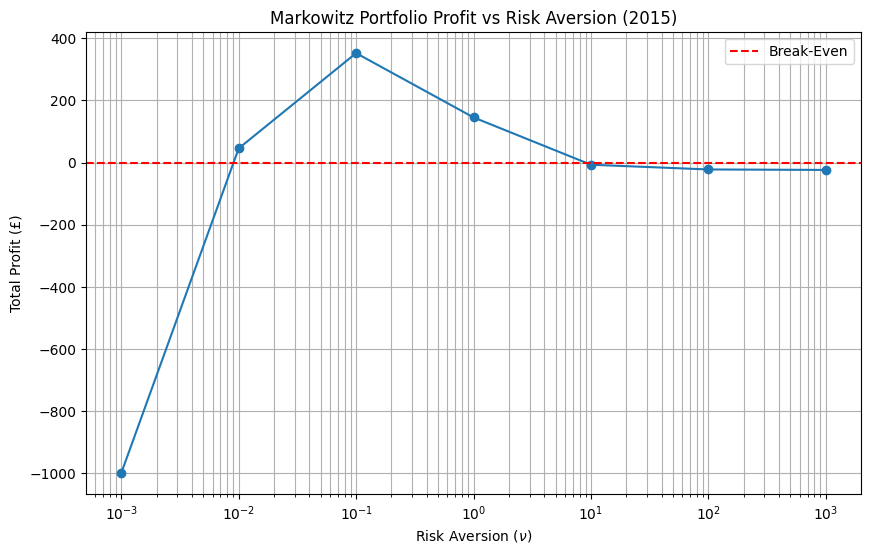

In [42]:
REF_PLAYER = "Agassi A."
REF_SURFACE = "Hard"

df_train, df_test = load_and_prep_data(df)
base_map, inter_map, n_total = get_feature_maps(df_train, REF_PLAYER, REF_SURFACE)
X_train, y_train = build_design_matrix(df_train, base_map, inter_map, n_total,
                                        REF_SURFACE, is_training=True)
X_test, _ = build_design_matrix(df_test, base_map, inter_map, n_total,
                                REF_SURFACE, is_training=False)
probs_2015 = train_and_predict(X_train, y_train, X_test)
odds_w = df_test['B365W'].values
odds_l = df_test['B365L'].values

Q_base, q_vec = build_qp_components(probs_2015, odds_w, odds_l)
nu_values = [1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0]
profits = []

print("-" * 35)
print(f"{'Nu':<10} | {'Profit (£)':>15}")
print("-" * 35)

for nu in nu_values:
    weights = solve_portfolio(Q_base, q_vec, nu, budget=1000.0)
    prof = calculate_actual_profit(weights, odds_w, odds_l)
    profits.append(prof)
    print(f"{nu:<10.4f} | {prof:>15.2f}")

plt.figure(figsize=(10, 6))
plt.plot(nu_values, profits, marker='o', linestyle='-')
plt.xscale('log')
plt.axhline(0, color='red', linestyle='--', label='Break-Even')
plt.xlabel(r'Risk Aversion ($\nu$)')
plt.ylabel('Total Profit (£)')
plt.title('Markowitz Portfolio Profit vs Risk Aversion (2015)')
plt.grid(True, which="both")
plt.legend()
plt.show()

For low $\nu$ the profits are highly volatile. With low risk aversion, the solver puts almost the entire £1,000 budget on the single match with the highest expected edge ($p_i \times \text{Odds} - 1$). If the model correctly identified a massive upset or a mispriced favorite, then we make a huge profit. Otherwise, we lose nearly everything.

For high \nu$, the profits will likely stabilise, typically converging towards a small loss. The penalty for variance becomes dominant and the portfolio spreads the £1,000 across many matches to diversify risk. It tends to favor betting on heavy favorites because the variance of such bets is lower than the long-shots.



---

The variance of the profits $R$ in the definition of the Markowitz portfolio assumes that the probability of each outcome for each match is known exactly. This does not take into account the uncertainty of the model parameters, which can increase a portfolio's risk. A Bayesian Markowitz portfolio assumes that the probabilities predicted for each match by the model are random and distributed according to some posterior distribution. The expectation and variance take into account this source of randomness.

Let $\theta$ represent the model parameters distributed according to a posterior distribution. Let $P_i(\theta)$ be the probability that the "Winner" wins match $i$ given parameters $\theta$. The profit for match $i$, denoted $R_i$, depends on the outcome $X_i \in \{0, 1\}$ and the bets $\phi_i$
\begin{equation}
    R = \sum_{i=1}^k R_i(\phi_i, X_i).
\end{equation}
We apply the law of iterated expectations, conditioning on the model parameters $\theta$
\begin{equation}
    E[R] = E_{\theta} [E_{X|\theta} [R \mid \theta]].
\end{equation}
For a fixed $\theta$, the expected return is linear in $\phi$. Let $q(\theta)$ be the vector of expected returns given parameters $\theta$. Then
\begin{equation}
    E_{X|\theta} [R \mid \theta] = q(\theta)^\top \phi,
\end{equation}
and substituting this back yields
\begin{equation}
    E[R] = E_{\theta} [ q(\theta)^\top \phi ] = (E_{\theta}[q(\theta)])^\top \phi.
\end{equation}
Let $\bar{q} = E_{\theta}[q(\theta)]$. This is the vector of expected returns calculated using the posterior mean probabilities for each match. Since $\bar{q}$ is independent of $\phi$, the term $-E[R]$ is linear in $\phi$.

We apply the law of total variance to decompose the variance into two components, namely, aleatoric uncertainty (match outcomes) and epistemic uncertainty (parameter uncertainty).
\begin{equation}
    \text{Var}(R) = E_{\theta} [\text{Var}_{X|\theta}(R \mid \theta)] + \text{Var}_{\theta}(E_{X|\theta}[R \mid \theta]).
\end{equation}
For a fixed $\theta$, the match outcomes are independent. The variance is a quadratic form given by the block-diagonal matrix $Q(\theta)$
\begin{equation}
    \text{Var}_{X|\theta}(R \mid \theta) = \phi^\top Q(\theta) \phi,
\end{equation}
so by taking the expectation over $\theta$, the first term becomes
\begin{equation}
    E_{\theta} [ \phi^\top Q(\theta) \phi ] = \phi^\top (E_{\theta}[Q(\theta)]) \phi.
\end{equation}
Let $\bar{Q} = E_{\theta}[Q(\theta)]$. Since $Q(\theta)$ is positive semi-definite for all $\theta$, its expectation $\bar{Q}$ is also positive-semi-definite. This term is quadratic in $\phi$.

Recall that $\mathbb{E}_{X|\theta}[R \mid \theta] = q(\theta)^\top \phi$ so the second term becomes
\begin{equation}
    \text{Var}_{\theta} ( q(\theta)^\top \phi )  = \phi^\top \text{Cov}_{\theta} \Big( q(\theta) \Big) \phi.
\end{equation}
Let $\Sigma_q = \text{Cov}_{\theta}(q(\theta))$ be the covariance matrix of the expected return vectors. Since $\Sigma_q$ is a covariance matrix, it is necessarily positive semi-definite. Note that unlike $\bar{Q}$, $\Sigma_q$ is not diagonal because model parameters affect predictions for all matches simultaneously, introducing correlation between the expected returns of different matches. This term is also quadratic in $\phi$.

Combining the terms, the total objective function is
\begin{align}
    f(\phi)
    &= - \bar{q}^\top \phi + \nu (\phi^\top \bar{Q} \phi + \phi^\top \Sigma_q \phi) \\
    &= \phi^\top \Big( \nu (\bar{Q} + \Sigma_q) \Big) \phi - \bar{q}^\top \phi.
\end{align}
Let $\mathcal{Q}_{Bayes} = \nu (\bar{Q} + \Sigma_q)$. Since both $\bar{Q}$ and $\Sigma_q$ are positive semi-definite, their sum is positive semi-definite. Hence, the problem can be written as as quadratic program
\begin{equation}
    \text{minimise} \quad \phi^\top \mathcal{Q}_{Bayes} \phi - \bar{q}^\top \phi \quad \text{subject to} \quad 1^\top \phi = 1000, \quad \phi \geq 0.
\end{equation}


---

In reality bets are made sequentially, as we wouldn't know which matches are played in 2015 in advance. One approach to sequential betting is the Kelly criterion. Before match $i$, we bet fractions $\phi_{i,W}$ and $\phi_{i,L}$ of our current bankroll on the winner and loser of the match, which maximise the expectation of the logarithm of the bankroll after the bet.

Here, $\phi_{i,W}$, $\phi_{i,L}$ are constrained to be non-negative and $\phi_{i,W} + \phi_{i,L} \leq 1$. The fractional Kelly strategy further reduces the risk by staking fractions $\rho\phi_{i,W}$ and $\rho\phi_{i,L}$ of the bankroll on each player, where $\rho$ is a constant smaller than $1$.

In [43]:
def get_data_and_predictions(df):
    df['Year'] = df['Date'].dt.year
    df = df.dropna(subset=['B365W', 'B365L']).copy()
    df_train = df[(df['Year'] >= 2000) & (df['Year'] <= 2014)].copy()
    df_test = df[df['Year'] == 2015].copy()

    players = sorted(list(set(df_train['Winner']) | set(df_train['Loser'])))
    surfaces = sorted(list(df_train['Surface'].unique()))
    ref_player = "Agassi A."
    ref_surface = "Hard"

    base_vars = [p for p in players if p != ref_player]
    inter_vars = [f"{p}_{s}" for p in players for s in surfaces if s != ref_surface]

    base_map = {p: i for i, p in enumerate(base_vars)}
    n_base = len(base_vars)
    inter_map = {feat: (i + n_base) for i, feat in enumerate(inter_vars)}
    n_total = n_base + len(inter_vars)

    def build_matrix(data, is_train=False):
        rows, cols, vals, y = [], [], [], []
        winners, losers, surfs = data['Winner'].values, data['Loser'].values, data['Surface'].values

        for i in range(len(data)):
            w, l, s = winners[i], losers[i], surfs[i]

            def add(r, p, sign):
                if p in base_map:
                    rows.append(r); cols.append(base_map[p]); vals.append(sign)
                if s != ref_surface:
                    k = f"{p}_{s}"
                    if k in inter_map:
                        rows.append(r); cols.append(inter_map[k]); vals.append(sign)

            # Row 1: W - L (y=1)
            idx = len(y)
            add(idx, w, 1); add(idx, l, -1)
            y.append(1)

            if is_train:
                idx = len(y)
                add(idx, w, -1); add(idx, l, 1)
                y.append(0)

        return sp.csr_matrix((vals, (rows, cols)), shape=(len(y), n_total)), np.array(y)

    X_train, y_train = build_matrix(df_train, is_train=True)
    X_test, _ = build_matrix(df_test, is_train=False)

    model = LogisticRegression(C=1e10, fit_intercept=False, solver='lbfgs')
    model.fit(X_train, y_train)

    # Get Probabilities (Winner wins)
    probs = model.predict_proba(X_test)[:, 1]

    # Return 2015 data sorted by date with probs
    df_test['ModelProb'] = probs
    return df_test.sort_values(by='Date')


def compute_kelly_fractions(prob_w, odds_w, odds_l, grid_size=101):
    '''
    Finds optimal f_w, f_l to maximize Expected Log Growth.
    '''
    prob_l = 1.0 - prob_w

    # Expected edges (If both negative, don't bet)
    edge_w = prob_w * odds_w - 1
    edge_l = prob_l * odds_l - 1

    if edge_w <= 0 and edge_l <= 0:
        return 0.0, 0.0


    # We construct a grid of values between 0 and 1
    fractions = np.linspace(0, 0.5, grid_size) # Rarely optimal to bet > 50%
    best_g = -np.inf
    best_fw, best_fl = 0.0, 0.0

    # Check for Winner side (assuming f_l = 0)
    # G = p * ln(1 + f(Ow-1)) + (1-p) * ln(1 - f)
    # If we bet on W, then outcomes are
    # W wins (grow by f*(Ow-1)), W loses (shrink by f)
    if edge_w > 0:
        g_vals = prob_w * np.log(1 + fractions * (odds_w - 1)) + \
                 prob_l * np.log(1 - fractions)
        best_idx = np.argmax(g_vals)
        if g_vals[best_idx] > 0:
            best_fw = fractions[best_idx]
            best_g = g_vals[best_idx]

    # Check for Loser side (assuming f_w = 0)
    if edge_l > 0:
        g_vals = prob_l * np.log(1 + fractions * (odds_l - 1)) + \
                 prob_w * np.log(1 - fractions)
        best_idx = np.argmax(g_vals)
        if g_vals[best_idx] > best_g and g_vals[best_idx] > 0:
            best_fl = fractions[best_idx]
            best_fw = 0.0 # Reset fw if fl is better

    return best_fw, best_fl

def run_simulation(df_sim, rho=0.1):
    bankroll = 1000.0
    history_dates = []
    history_vals = []

    # Initial state
    if not df_sim.empty:
        history_dates.append(df_sim['Date'].iloc[0] - pd.Timedelta(days=1))
        history_vals.append(bankroll)

    for _, row in df_sim.iterrows():
        p = row['ModelProb']
        o_w = row['B365W']
        o_l = row['B365L']

        # Compute Optimal Full Kelly
        k_w, k_l = compute_kelly_fractions(p, o_w, o_l)

        # Apply Fractional Kelly
        f_w = rho * k_w
        f_l = rho * k_l

        # Bet Amounts
        stake_w = bankroll * f_w
        stake_l = bankroll * f_l

        # Update Bankroll
        profit = (stake_w * (o_w - 1.0)) - stake_l
        bankroll += profit

        # Record
        history_dates.append(row['Date'])
        history_vals.append(bankroll)

    return history_dates, history_vals

Final Bankroll: £458.33
Total Return:   -54.17%


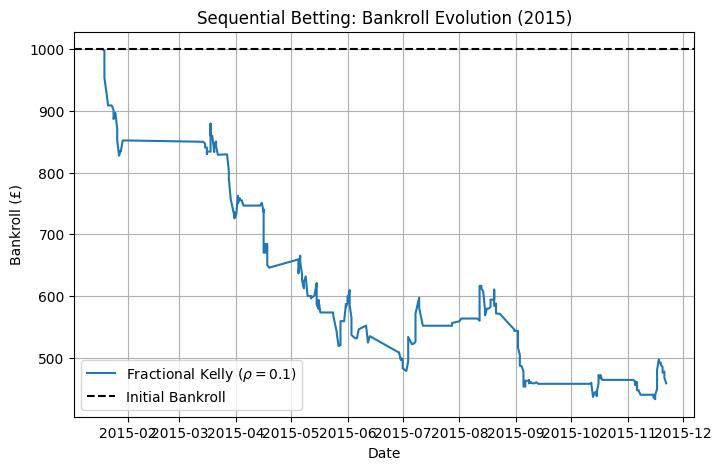

In [49]:
df_2015 = get_data_and_predictions(df)
dates, values = run_simulation(df_2015, rho=0.1)

plt.figure(figsize=(8, 5))
plt.plot(dates, values, label=r'Fractional Kelly ($\rho=0.1$)')
plt.axhline(1000, color='black', linestyle='--', label='Initial Bankroll')
plt.title("Sequential Betting: Bankroll Evolution (2015)")
plt.xlabel("Date")
plt.ylabel("Bankroll (£)")
plt.legend()
plt.grid(True)

final_br = values[-1]
ret = (final_br - 1000) / 1000 * 100
print(f"Final Bankroll: £{final_br:,.2f}")
print(f"Total Return:   {ret:.2f}%")
plt.show()

The strategy resulted in a significant loss. There are significant steep drops early on which suggest that the model's predictions were consistently incorrect relative to the betting odds. The use of $\rho = 0.1$ likely saved the portfolio from total ruin. There were also periods where the line is flat. This indicates times where either few matches were played, or more likely, the model found no value bets.

The failure of the strategy highlights the difficulty of outperforming efficient betting markets using a relatively simple statistical model. Bookmaker odds are not fair probabilities as they must include a margin to make a profit. Furthermore, the Kelly criterion is aggressive as it assumes the calculated probability $p$ is the true probability.

The model was trained on data from 2000-2014 and applied to 2015. It treats a player's ability as fixed and does not account for changing ability, emerging talent or form.